In [1]:
import HHBlits
import get_cullin_e3_ppi_from_pdb70
import cullin_benchmark_test
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from pathlib import Path
import scipy as sp
from Bio import SeqIO

# Helper functions

#NOTES
#The analysis doesn't include vif which it needs to run HHBlits for vif and other viral proteins
#There are a few hub pdbs (maybe visualize as a netowrk...) with many uids
#

#Load in some notebook globals
cullin_benchmark = cullin_benchmark_test.CullinBenchMark(
    dirpath=Path("../../data/raw/cullin_e3_ligase/"))

In [2]:
nb_globals = {}
nb_globals["n_bait"] = len(set(cullin_benchmark.data["Bait"]))
nb_globals["n_prey"] = len(set(cullin_benchmark.data["Prey"]))
nb_globals["n_failed"] = len(set(cullin_benchmark.failed))

# What is the distribution of sequence lengths in query uniprot ids?
# Because if the sequences are short it is likely to get many hits



suffix = "wt_MG132"
bait_elob = f"ELOB{suffix}"
bait_cbfb = f"CBFB{suffix}"
bait_cul5 = f"CUL5{suffix}"

In [3]:
pdb_uid_0dot9: dict = get_cullin_e3_ppi_from_pdb70.step4(prob_threshold=0.9, 
                                                         dev_path=True,
                                                         verbose=False)

# A particular uniprot id can "hit" the same pdb multiple times in HHBlits because there may be multiple
# chains within the complex
# Therefore it is important to distinguish the set of unique uniprot ids, meaning at least 1 chain was found

unique_pdb_uid_0dot9 = {key: set(val) for key, val in pdb_uid_0dot9.items()}

#for key, value in pdb_uid_0dot9.items():
    #assert len(set(value)) == len(value), f"{key} N-unique {len(set(value))}, N-total {len(value)}"
    
def get_n_uids_per_pdb(d):
    n_uids = {pdb_id: len(uids) for pdb_id, uids in d.items()}
    n_uniprot_ids_per_pdb_id = [val for _, val in n_uids.items()]
    n_uniprot_ids_per_pdb_id = sorted(n_uniprot_ids_per_pdb_id, reverse=True)
    return n_uniprot_ids_per_pdb_id

n_uniprot_ids_per_pdb_id = get_n_uids_per_pdb(pdb_uid_0dot9)
n_unique_uniprot_ids_per_pdb_id = get_n_uids_per_pdb(unique_pdb_uid_0dot9)

In [4]:
unique_prey_df = pd.DataFrame(columns=["Prey", "MaxSaintScore", "SeqLen", "N-pdb90"])
unique_prey_df["Prey"] = list(set(cullin_benchmark.data["Prey"]))

n_pdb_ids = {prey: 0 for prey in unique_prey_df["Prey"]}

assert len(set(unique_pdb_uid_0dot9.keys())) == len(unique_pdb_uid_0dot9.keys())

for pdb_id, uids in unique_pdb_uid_0dot9.items():
    for uid in uids:
        assert uid in n_pdb_ids
        val = n_pdb_ids[uid]
        val += 1
        n_pdb_ids[uid] = val
    
    
for i, prey in enumerate(unique_prey_df["Prey"]):
    max_saint = max(cullin_benchmark.data[cullin_benchmark.data["Prey"]==prey]["SaintScore"])
    unique_prey_df.loc[i, "MaxSaintScore"] = max_saint
    
    #Get the number of PDBs shared by a single prey
    
    if prey in n_pdb_ids:
        unique_prey_df.loc[i, "N-pdb90"] = n_pdb_ids[prey]
    


fasta = SeqIO.parse("../../data/interim/cullin_e3_ligase/prey.fasta", "fasta")
for i, seq in enumerate(fasta):
    seq_len = len(seq.seq)
    uid = seq.description.split("|")[1]
    
    assert sum(unique_prey_df["Prey"]==uid)==1, f"{i, uid}"
    unique_prey_df.loc[unique_prey_df["Prey"]==uid, "SeqLen"] = seq_len
    
    
    
def summarize_dict(d: dict):
    s  = (f"N-keys {len(d.keys())}")
    return s

Text(0, 0.5, 'Sequence Length')

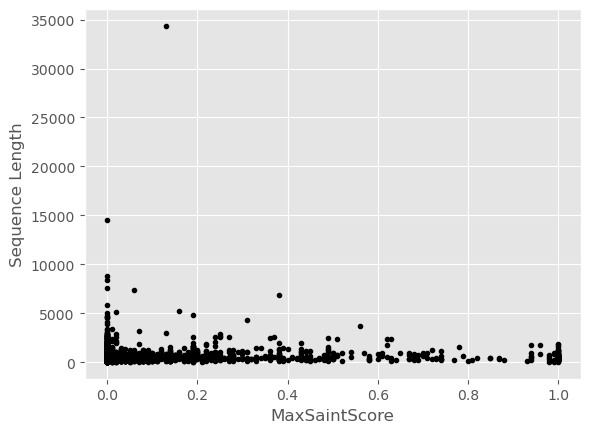

In [5]:
plt.style.use("ggplot")
plt.plot(unique_prey_df["MaxSaintScore"], unique_prey_df["SeqLen"], 'k.')
plt.xlabel("MaxSaintScore")
plt.ylabel("Sequence Length")

Text(0, 0.5, 'N-pdb90')

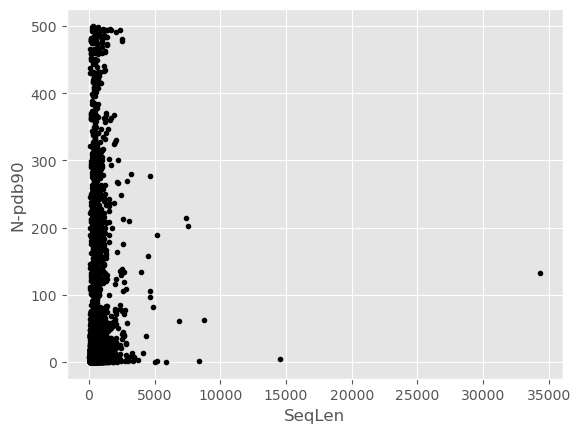

In [6]:
x = "N-pdb90"
y = "SeqLen"
t = x
x = y
y = t

# exluding very long sequences




plt.style.use("ggplot")
plt.plot(unique_prey_df[x], unique_prey_df[y], 'k.')
plt.xlabel(x)
plt.ylabel(y)

Text(0, 0.5, 'N-pdb90')

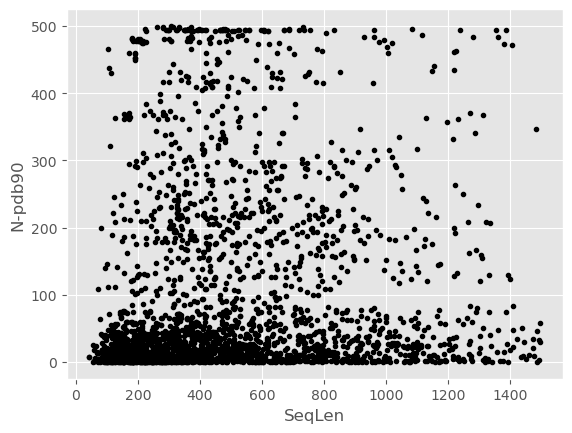

In [7]:
max_len = 1500
row_indexer = unique_prey_df["SeqLen"] < max_len
df = unique_prey_df[row_indexer]

plt.style.use("ggplot")
plt.plot(df[x], df[y], 'k.')
plt.xlabel(x)
plt.ylabel(y)

/home/aji/anaconda3/envs/pynet/lib/python3.11/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/aji/anaconda3/envs/pynet/lib/python3.11/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


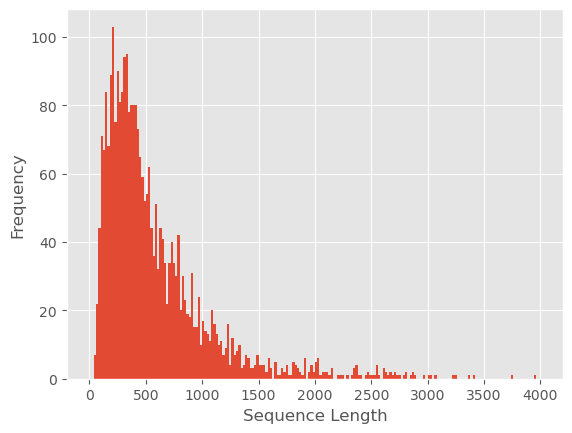

In [8]:
plt.hist(unique_prey_df["SeqLen"], bins=200, range=(0, 4000))
plt.xlabel("Sequence Length")
plt.ylabel("Frequency")
plt.show()

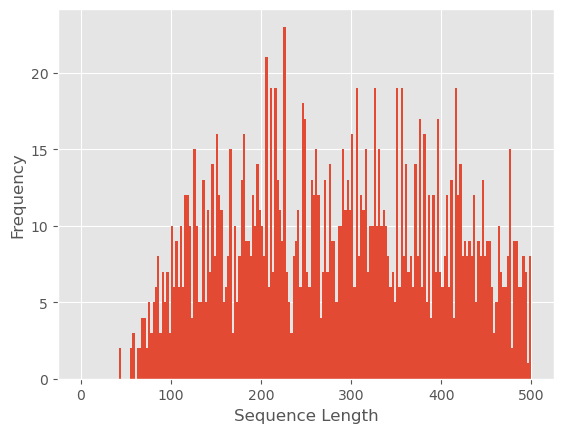

In [9]:
plt.hist(unique_prey_df["SeqLen"], bins=200, range=(0, 500))
plt.xlabel("Sequence Length")
plt.ylabel("Frequency")
plt.show()

Text(0, 0.5, 'MaxSaintScore')

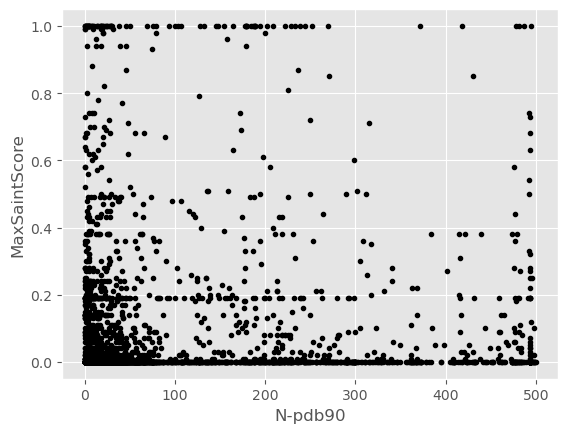

In [10]:
plt.style.use("ggplot")
plt.plot(unique_prey_df["N-pdb90"], unique_prey_df["MaxSaintScore"], 'k.')
plt.xlabel("N-pdb90")
plt.ylabel("MaxSaintScore")

In [11]:
row_indexer = unique_prey_df["SeqLen"] > 10000
unique_prey_df[row_indexer]

,Prey,MaxSaintScore,SeqLen,N-pdb90
202,Q8WZ42,0.13,34350,132
1163,Q8WXI7,0.0,14507,4


In [ ]:
# Build a dataframe indexed by the pdb_id
pdb_id_df = pd.DataFrame(index = range(len(pdb_uid_0dot9)), 
                         columns=["pdb_id", "n-hits", "n-unique-hits"])


for i, t in enumerate(pdb_uid_0dot9.items()):
    pdb_id, uids = t
    n_hits = len(uids)
    n_unique_hits = len(set(uids))
    
    assert n_hits > 0, f"{i, pdb_id, n_hits}"
    assert n_unique_hits > 0
    pdb_id_df.loc[i, ["pdb_id", "n-hits", "n-unique-hits"]] = pdb_id, n_hits, n_unique_hits

In [70]:
pdb_id_df["n-hits"] = pd.to_numeric(pdb_id_df["n-hits"])
pdb_id_df["n-unique-hits"] = pd.to_numeric(pdb_id_df["n-unique-hits"])
    

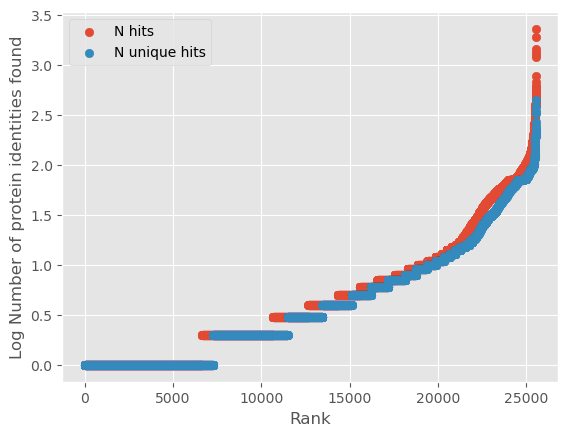

In [76]:
#alphas = [0.01]*len(n_unique_uniprot_ids_per_pdb_id)

start=1
stop=len(pdb_id_df) + 1
log = True
x = np.arange(start, stop)


y1 = sorted(pdb_id_df['n-unique-hits'])
y2 = sorted(pdb_id_df['n-hits'])

if log:
    y1 = np.log10(y1)
    y2 = np.log10(y2)
    

plt.style.use("ggplot")
plt.scatter(x, y2, label="N hits")
plt.scatter(x, y1, alpha=None, label="N unique hits")


plt.ylabel("Log Number of protein identities found")
plt.xlabel("Rank")
plt.legend()

In [80]:
pdb_id_df.sort_values("n-hits")

,pdb_id,n-hits,n-unique-hits
25561,3VX7,1,1
5501,6ECB,1,1
19392,1KCM,1,1
19393,4V67,1,1
19395,1J3A,1,1
...,...,...,...
575,3JB9,1253,332
607,6ID1,1346,376
566,7DCO,1439,441
563,6RXU,1889,247


In [96]:
#Lets create the NxN adjacency matrix
# Does not yet include vif!
N = len(unique_prey_df)
A = np.zeros((N, N))

prey_indicies = {prey: index for index, prey in enumerate(unique_prey_df["Prey"])}

In [102]:
# Fill in the weighted adjacency matrix
for pdb_id, uids in pdb_uid_0dot9.items():
    unique_uids = list(set(uids))
    l = len(unique_uids)
    if l > 1:
        for i in range(0, l):
            for j in range(i+1, l):
                assert i != j
                prey_u = unique_uids[i]
                prey_v = unique_uids[j]
                
                assert prey_u != prey_v
                
                index_u = prey_indicies[prey_u]
                index_v = prey_indicies[prey_v]
                
                assert index_u != index_v
                
                value = A[index_u, index_v]
                value = value + 1
                A[index_u, index_v] = value

In [109]:
# Let's visualize the network of interactions at 90% probability
# These ~ 9,000,000 operations take longer than I would expect
# over 10 min on 1 cpu - could parallize
# takes ~30min - 1hr to run 
from pyvis.network import Network
net = Network()
for i, uid in enumerate(prey_indicies.keys()):
    net.add_node(i, label=uid)
    
for i in range(N):
    for j in range(i + 1, N):
        value = A[i, j]
        if value > 0:
            net.add_edge(i, j, value=value)
        
net.show("example.html")

In [13]:
# Why is it that a few PDB ids have many (1000s) of hits in them?

max(n_uniprot_ids_per_pdb_id)

2291

In [24]:
n_unique_uniprot_ids_per_pdb_id

[441,
 376,
 338,
 337,
 332,
 327,
 270,
 247,
 231,
 228,
 220,
 216,
 215,
 210,
 201,
 201,
 199,
 199,
 196,
 195,
 193,
 193,
 192,
 188,
 183,
 180,
 177,
 176,
 176,
 175,
 172,
 161,
 158,
 157,
 151,
 150,
 147,
 146,
 146,
 145,
 143,
 143,
 143,
 140,
 139,
 136,
 135,
 133,
 132,
 132,
 131,
 130,
 130,
 129,
 127,
 127,
 127,
 127,
 126,
 126,
 126,
 125,
 125,
 124,
 123,
 122,
 122,
 121,
 120,
 120,
 119,
 119,
 119,
 119,
 118,
 118,
 118,
 117,
 116,
 116,
 115,
 115,
 115,
 114,
 114,
 113,
 112,
 112,
 111,
 111,
 111,
 111,
 111,
 110,
 110,
 110,
 110,
 109,
 108,
 108,
 107,
 107,
 107,
 107,
 106,
 105,
 105,
 104,
 104,
 104,
 104,
 104,
 103,
 102,
 102,
 102,
 102,
 102,
 101,
 101,
 101,
 101,
 101,
 101,
 100,
 100,
 100,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 98,
 98,
 98,
 97,
 97,
 97,
 97,
 97,
 97,
 97,
 96,
 96,
 96,
 96,
 96,
 96,
 96,
 96,
 96,
 96,
 96,
 96,
 96,
 95,
 95,
 95,
 95,
 95,
 95,
 95,
 95,
 95,
 95,
 95,
 95,
 95,
 95,
 95

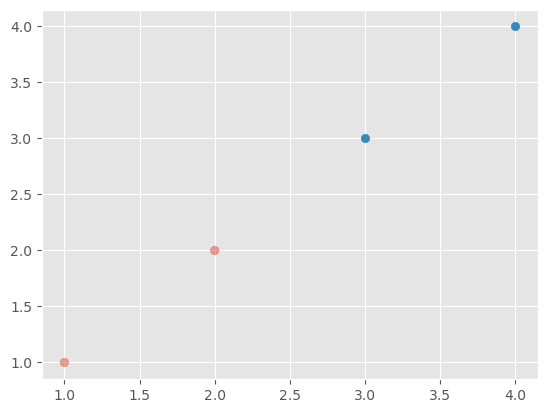

In [14]:
plt.scatter([1, 2], [1, 2], alpha=[0.5]*2)
plt.scatter([3, 4], [3, 4])

Text(0.5, 0, 'Rank')

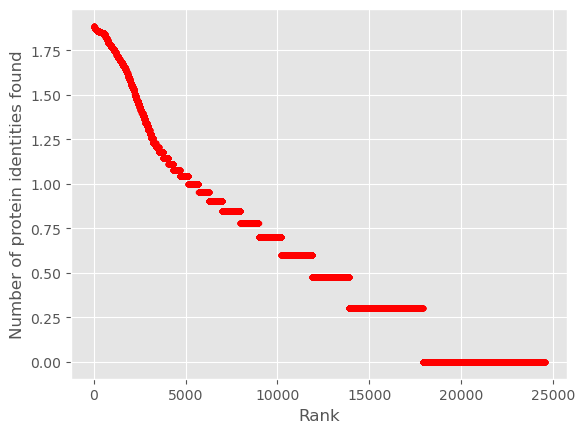

In [15]:
# Removing the top 100 solutions because it's weird to have 2000 hits per pdb_id
start = 0
stop = 1000
plt.style.use("ggplot")
plt.plot(np.arange(1, len(n_uniprot_ids_per_pdb_id[stop:-1]) + 1), np.log10(n_uniprot_ids_per_pdb_id[stop:-1]), 'r.')
plt.ylabel("Number of protein identities found")
plt.xlabel("Rank")

Text(0.5, 0, 'Rank')

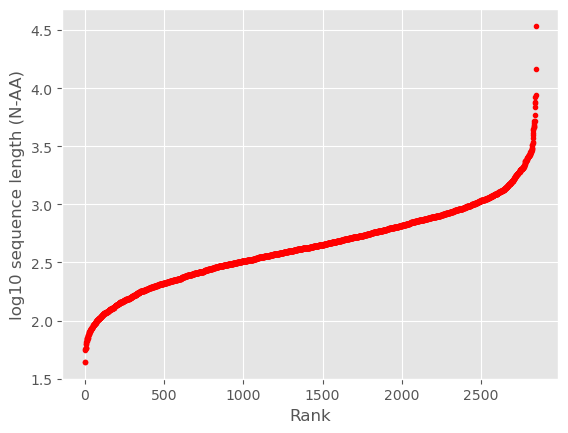

In [17]:
# What is the distribution of sequence lengths in query uniprot ids?
# Because if the sequences are short it is likely to get many hits

fasta = SeqIO.parse("../../data/interim/cullin_e3_ligase/prey.fasta", "fasta")
fasta_lengths = sorted([len(seq.seq) for seq in fasta])

plt.plot(np.arange(1, len(fasta_lengths) + 1), np.log10(np.array(fasta_lengths)), 'r.')
plt.ylabel("log10 sequence length (N-AA)")
plt.xlabel("Rank")

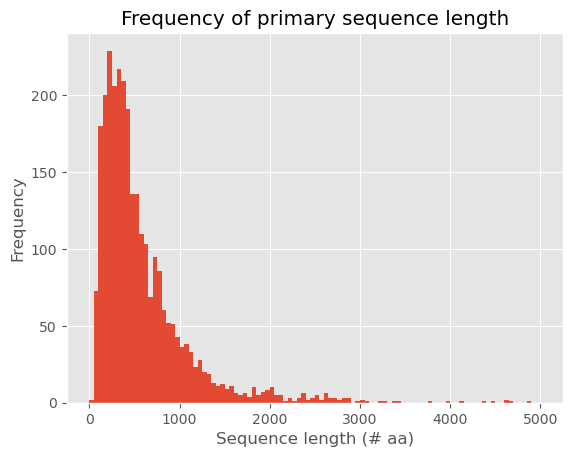

In [18]:
plt.hist(fasta_lengths, bins=100, range=(1, 5000))
plt.xlabel("Sequence length (# aa)")
plt.ylabel("Frequency")
plt.title("Frequency of primary sequence length")
plt.show()

In [19]:
# Filter out sequences less than the length of vif
# vif has the id P69723
vifprotein = "MENRWQVMIVWQVDRMRIRTWKSLVKHHMYVSGKARGWFYRHHYESPHPRISSEVHIPLGDARLVITTYWGLHTGERDWHLGQGVSIEWRKKRYSTQVDPELADQLIHLYYFDCFSDSAIRKALLGHIVSPRCEYQAGHNKVGSLQYLALAALITPKKIKPPLPSVTKLTEDRWNKPQKTKGHRGSHTMNGH"
fasta = SeqIO.parse("../../data/interim/cullin_e3_ligase/prey.fasta", "fasta")
for i, seq in enumerate(fasta):
    uid = seq.description.split("|")[1]
    if str(uid) == "P69723":
        vifseq = seq
    
    

In [20]:
len(vifprotein)

192

In [21]:
fasta

In [22]:
%%bash
ls ../../data/interim/cullin_e3_ligase/
grep ">" ../../data/interim/cullin_e3_ligase/prey.fasta | wc -l

hhblits_out
id_mapping.csv
prey.fasta
prey.fasta~
prey.fasta_original
prey_proteins.csv
prey_proteins.csv~
preys
write_fastas.py
write_fastas.py~
2846
